In [30]:
from pathlib import Path
import pandas as pd
import gensim, spacy
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from joblib import Memory
import os
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import pyLDAvis
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore")

In [31]:
BASE_DIR = Path.cwd().parent
stop_words = stopwords.words('english')
cachedir = os.path.join(BASE_DIR, 'cache')
memory = Memory(cachedir, verbose=0)

In [32]:
df_hosts_reviews_en = pd.read_parquet(BASE_DIR / 'staging_data' / 'hosts_reviews_en_cleaned.parquet')

In [33]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df_hosts_reviews_en['comments'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[1])

['nice', 'flat', 'great', 'area', 'host', 'sorted', 'things', 'make', 'stay', 'smooth', 'easy', 'leaving', 'key', 'neighbours', 'etc', 'thanks']


In [34]:
nlp = spacy.load("en_core_web_sm")
stop_words.append('also')
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
@memory.cache
def process_words_cached(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    #texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

# call the cached function
data_ready = process_words_cached(data_words)

In [35]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

lda_model.print_topics()

[(0,
  '0.049*"apartment" + 0.049*"great" + 0.047*"location" + 0.032*"stay" + 0.027*"nice" + 0.025*"easy" + 0.025*"place" + 0.023*"clean" + 0.021*"walk" + 0.020*"close"'),
 (1,
  '0.117*"host" + 0.047*"stay" + 0.033*"place" + 0.021*"great" + 0.021*"recommend" + 0.020*"really" + 0.020*"nice" + 0.017*"apartment" + 0.017*"helpful" + 0.015*"friendly"'),
 (2,
  '0.017*"room" + 0.017*"bed" + 0.017*"kitchen" + 0.013*"small" + 0.012*"apartment" + 0.011*"good" + 0.009*"bathroom" + 0.009*"get" + 0.009*"work" + 0.009*"little"')]

In [36]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,3), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic', 'percent_contribution', 'topic_keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    contents.name = 'text'
    sent_topics_df = (df_hosts_reviews_en.merge(sent_topics_df, left_index=True, right_index=True)
                                    .merge(contents, left_index=True, right_index=True)
                                    .drop('index', axis=1))
    return(sent_topics_df)


df_dominant_topic = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)
df_dominant_topic.head()

,date,listing_id_encod,listing_id,reviewer_id,reviewer_name,comments,host_id,host_name,host_description,neighbourhood,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,comments_language,description_language,dominant_topic,percent_contribution,topic_keywords,text
0,2010-09-06,0.0,32984.0,200247.0,Keenan,great little apartment perfect spot town nice ...,53396.0,Chris,city hall stockholm beautiful bright 43 sqm 1b...,Kungsholmens,...,4.29,4.52,4.81,4.2,en,en,2,0.508,"room, bed, kitchen, small, apartment, good, ba...","[great, little, apartment, perfect, spot, town..."
1,2010-09-12,0.0,32984.0,126543.0,Olaf,nice flat great area host sorted things make s...,53396.0,Chris,city hall stockholm beautiful bright 43 sqm 1b...,Kungsholmens,...,4.29,4.52,4.81,4.2,en,en,2,0.377,"room, bed, kitchen, small, apartment, good, ba...","[nice, flat, great, area, host, sort, thing, m..."
2,2011-05-21,0.0,32984.0,294223.0,Max,great location host responsive email country t...,53396.0,Chris,city hall stockholm beautiful bright 43 sqm 1b...,Kungsholmens,...,4.29,4.52,4.81,4.2,en,en,2,0.560,"room, bed, kitchen, small, apartment, good, ba...","[great, location, host, responsive, email, cou..."
3,2011-05-28,0.0,32984.0,577190.0,Eli,host place super great close everything quite ...,53396.0,Chris,city hall stockholm beautiful bright 43 sqm 1b...,Kungsholmens,...,4.29,4.52,4.81,4.2,en,en,0,0.719,"apartment, great, location, stay, nice, easy, ...","[host, place, super, great, close, quite, cent..."
4,2011-06-11,0.0,32984.0,521818.0,Jonathan,nice apartment great location great price host...,53396.0,Chris,city hall stockholm beautiful bright 43 sqm 1b...,Kungsholmens,...,4.29,4.52,4.81,4.2,en,en,0,0.363,"apartment, great, location, stay, nice, easy, ...","[nice, apartment, great, location, great, pric..."


In [37]:
df_dominant_topic.to_parquet(BASE_DIR / 'processed_data' / 'hosts_reviews_en_topics.parquet')

In [38]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.171347  0.158374       1        1  38.358878
1     -0.125924 -0.175373       2        1  34.056371
2      0.297271  0.016999       3        1  27.584751, topic_info=        Term          Freq         Total Category  logprob  loglift
28      host  63504.000000  63504.000000  Default  30.0000  30.0000
48  location  25578.000000  25578.000000  Default  29.0000  29.0000
8      great  35064.000000  35064.000000  Default  28.0000  28.0000
7       easy  13255.000000  13255.000000  Default  27.0000  27.0000
70     close  10487.000000  10487.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
89     check   2306.296712   5748.219643   Topic3  -5.0937   0.3747
31      make   2057.120255   6639.576395   Topic3  -5.2080   0.1162
64      time   2129.134859   8743.246294   Topic3  -5.1736  -0.1247
38     clean   2211.835013  20174.098579   Topic3  -5.1355  -0.9227
50      need   1915.813329  12016.896998   Topic3  -5.2792  -0.5483

[204 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
641       1  0.034165  accommodate
641       2  0.965172  accommodate
115       2  0.999695       always
345       1  0.316336      amazing
345       2  0.683443      amazing
...     ...       ...          ...
605       3  0.999161         wifi
885       3  0.999702       window
236       1  0.310501    wonderful
236       2  0.689465    wonderful
619       3  0.999671         work

[256 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [39]:
topics = lda_model.show_topics(formatted=False)

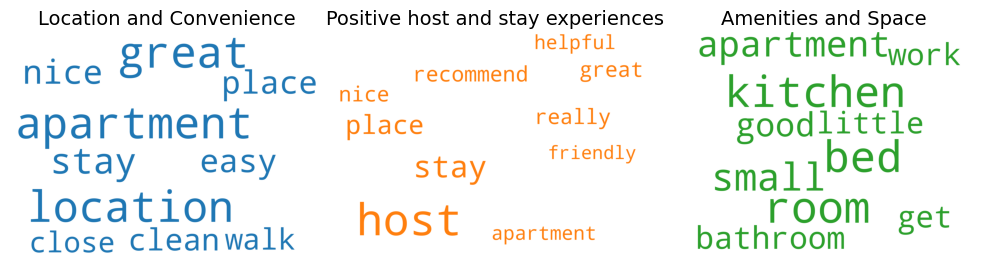

In [43]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

groups = {1: 'Positive host and stay experiences',
          0: 'Location and Convenience',
          2: 'Amenities and Space'
        }

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=350)
    plt.gca().imshow(cloud)
    plt.gca().set_title(groups.get(i), fontdict=dict(size=14))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=30, hspace=20)
plt.axis('off')
#plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()